In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet121, EfficientNetB0
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns
from keras.callbacks import LearningRateScheduler

In [ ]:
train_path= '../input/bone-fracture-detection-using-xrays/archive (6)/train'
test_path='../input/bone-fracture-detection-using-xrays/archive (6)/val'

In [ ]:
train_datagen = image.ImageDataGenerator(
    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1
)
val_datagen= image.ImageDataGenerator(    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size = (224,224),
    batch_size = 4,
    class_mode = 'binary')
validation_generator = val_datagen.flow_from_directory(
    test_path,
    target_size = (224,224),
    batch_size = 4,
    shuffle=True,
    class_mode = 'binary')

**CNN**

In [ ]:
# Model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.summary()

In [ ]:
# Compile the model with specified optimizer, loss, and metrics
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy', 'Precision', 'Recall', 'AUC'])

In [ ]:
# Define Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

In [ ]:
# Define callbacks
filepath = 'best_model_cnn.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

In [ ]:
# Define Learning Rate Scheduler
def schedule(epoch, learning_rate):
    if epoch < 10:
        return 0.001
    else:
        return learning_rate * 0.9

lr_scheduler = LearningRateScheduler(schedule)

In [ ]:
# Combine callbacks in a list
callbacks = [checkpoint, early_stopping, lr_scheduler]

# Fit the model with callbacks
history = model.fit(train_generator, epochs=10,steps_per_epoch= 50, callbacks=callbacks)

In [ ]:
# Plot training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Evaluate the model on the validation set
validation_eval = model.evaluate(validation_generator)

# Generate predictions on the validation set
y_pred = model.predict(validation_generator)

# Get true labels
y_true = validation_generator.classes

from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
# Confusion matrix
cm = confusion_matrix(y_true, np.round(y_pred))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('cnncm')
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.savefig('cnnroc')
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_true, y_pred)
average_precision = average_precision_score(y_true, y_pred)
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (AP={:.2f})'.format(average_precision))
plt.savefig('cnnrc')
plt.show()

**VGG**

In [ ]:
# Load pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze convolutional layers
for layer in base_model.layers:
    layer.trainable = False

# Create a new model on top of the VGG16 base
vggmodel = models.Sequential()
vggmodel.add(base_model)
vggmodel.add(layers.Flatten())
vggmodel.add(layers.Dense(512, activation='relu'))
vggmodel.add(layers.Dropout(0.5))
vggmodel.add(layers.Dense(1, activation='sigmoid'))  # Binary classification, so 1 output neuron with sigmoid activation
vggmodel.summary()

In [ ]:
# Compile the model with specified optimizer, loss, and metrics
vggmodel.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall', 'AUC'])

In [ ]:
# Define callbacks
filepath = 'best_model_vgg.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
lrp = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=2)

# Combine callbacks in a list
callbacks = [checkpoint, early_stopping, lrp]

# Train the model with callbacks
history = vggmodel.fit(
    train_generator,
    epochs=10,
    steps_per_epoch= 50,
    callbacks=callbacks
)

In [ ]:
vggmodel.evaluate(validation_generator)

In [ ]:
# Plot training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Evaluate the model on the validation set
validation_eval = vggmodel.evaluate(validation_generator)

# Generate predictions on the validation set
y_pred = vggmodel.predict(validation_generator)

# Get true labels
y_true = validation_generator.classes

from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
# Confusion matrix
cm = confusion_matrix(y_true, np.round(y_pred))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('vggcm')
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.savefig('vggroc')
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_true, y_pred)
average_precision = average_precision_score(y_true, y_pred)
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (AP={:.2f})'.format(average_precision))
plt.savefig('vggrc')
plt.show()

**ResNet50**

In [22]:
# Load pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze convolutional layers
for layer in base_model.layers:
    layer.trainable = False

# Create a new model on top of the ResNet50 base
rsmodel = models.Sequential()
rsmodel.add(base_model)
rsmodel.add(layers.GlobalAveragePooling2D())
rsmodel.add(layers.Dense(512, activation='relu'))
rsmodel.add(layers.Dropout(0.5))
rsmodel.add(layers.Dense(1, activation='sigmoid'))  # Binary classification, so 1 output neuron with sigmoid activation
rsmodel.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 513       
Total params: 24,637,313
Trainable params: 1,049,601
Non-trainable params: 23,587,712
_________________________________________________________________


In [23]:
rsmodel.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall', 'AUC'])
# Compile the model with specified optimizer, loss, and metrics

In [24]:
# Define callbacks
filepath = 'best_model_rs.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
lrp = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=2)

# Combine callbacks in a list
callbacks = [checkpoint, early_stopping, lrp]

# Train the model with callbacks
history = rsmodel.fit(train_generator, epochs=10,steps_per_epoch= 50, callbacks=callbacks)

Epoch 1/10
50/50 [==============================] - 6s 56ms/step - loss: 1.4407 - accuracy: 0.5200 - precision: 0.5776 - recall: 0.5877 - auc: 0.5391
Epoch 2/10
50/50 [==============================] - 3s 59ms/step - loss: 1.0476 - accuracy: 0.5900 - precision: 0.5684 - recall: 0.5684 - auc: 0.6240
Epoch 3/10
50/50 [==============================] - 3s 60ms/step - loss: 0.7945 - accuracy: 0.6600 - precision: 0.6383 - recall: 0.6383 - auc: 0.6939
Epoch 4/10
50/50 [==============================] - 3s 56ms/step - loss: 0.6950 - accuracy: 0.6500 - precision: 0.6875 - recall: 0.6875 - auc: 0.6853
Epoch 5/10
50/50 [==============================] - 3s 56ms/step - loss: 0.6211 - accuracy: 0.6650 - precision: 0.6444 - recall: 0.6237 - auc: 0.7354
Epoch 6/10
50/50 [==============================] - 3s 57ms/step - loss: 0.6147 - accuracy: 0.6550 - precision: 0.6444 - recall: 0.6105 - auc: 0.7363
Epoch 7/10
50/50 [==============================] - 3s 61ms/step - loss: 0.5975 - accuracy: 0.6750 -

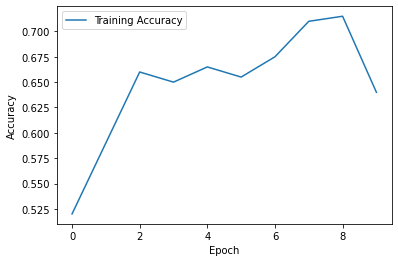

In [25]:
# Plot training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

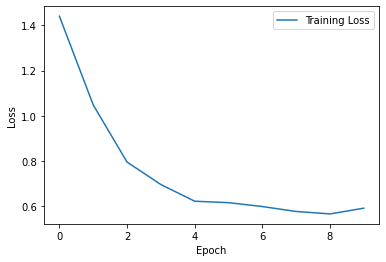

In [26]:
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

150/150 [==============================] - 11s 64ms/step - loss: 0.5482 - accuracy: 0.7033 - precision: 0.6000 - recall: 0.7750 - auc: 0.7756


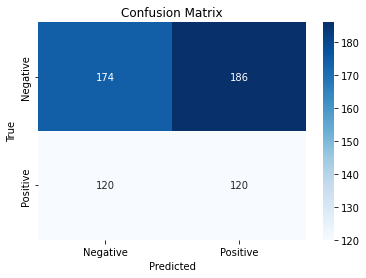

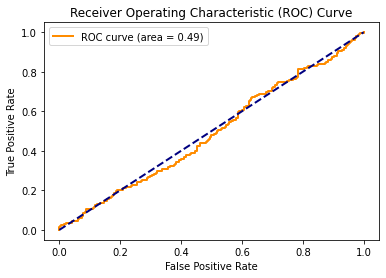

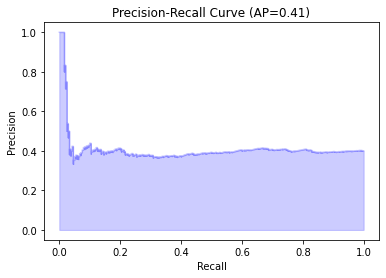

In [27]:
# Evaluate the model on the validation set
validation_eval = rsmodel.evaluate(validation_generator)

# Generate predictions on the validation set
y_pred = rsmodel.predict(validation_generator)

# Get true labels
y_true = validation_generator.classes

from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
# Confusion matrix
cm = confusion_matrix(y_true, np.round(y_pred))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('rscm')
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.savefig('rsroc')
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_true, y_pred)
average_precision = average_precision_score(y_true, y_pred)
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (AP={:.2f})'.format(average_precision))
plt.savefig('rsrc')
plt.show()

**DenseNet121**

In [28]:
# Load pre-trained DenseNet121 model
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze convolutional layers
for layer in base_model.layers:
    layer.trainable = False

# Create a new model on top of the DenseNet121 base
dnmodel = Sequential()
dnmodel.add(base_model)
dnmodel.add(GlobalAveragePooling2D())
dnmodel.add(Dense(512, activation='relu'))
dnmodel.add(Dropout(0.5))
dnmodel.add(Dense(1, activation='sigmoid'))  # Binary classification, so 1 output neuron with sigmoid activation
dnmodel.summary()

29097984/29084464 [==============================] - 0s 0us/step
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 7, 7, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 513       
Total params: 7,562,817
Trainable params: 525,313
Non-trainable params: 7,037,504
_________________________________________________________________


In [29]:
dnmodel.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall', 'AUC'])

In [30]:
# Define callbacks
filepath = 'best_model_dn.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
lrp = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=2)

# Combine callbacks in a list
callbacks = [checkpoint, early_stopping, lrp]

# Train the model with callbacks
history = dnmodel.fit(train_generator, epochs=10,steps_per_epoch= 50, callbacks=callbacks)


Epoch 1/10
50/50 [==============================] - 10s 59ms/step - loss: 2.8059 - accuracy: 0.5150 - precision: 0.4598 - recall: 0.4444 - auc: 0.5115
Epoch 2/10
50/50 [==============================] - 3s 62ms/step - loss: 2.1802 - accuracy: 0.5050 - precision: 0.5204 - recall: 0.4951 - auc: 0.4768
Epoch 3/10
50/50 [==============================] - 3s 66ms/step - loss: 1.6123 - accuracy: 0.4850 - precision: 0.4444 - recall: 0.4301 - auc: 0.5071
Epoch 4/10
50/50 [==============================] - 3s 57ms/step - loss: 1.3041 - accuracy: 0.5750 - precision: 0.5169 - recall: 0.5227 - auc: 0.5824
Epoch 5/10
50/50 [==============================] - 3s 58ms/step - loss: 1.0453 - accuracy: 0.5800 - precision: 0.5714 - recall: 0.5361 - auc: 0.5813
Epoch 6/10
50/50 [==============================] - 3s 59ms/step - loss: 0.7450 - accuracy: 0.5450 - precision: 0.5341 - recall: 0.4845 - auc: 0.5867
Epoch 7/10
50/50 [==============================] - 3s 58ms/step - loss: 0.7780 - accuracy: 0.5400 

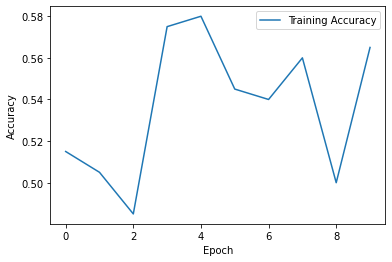

In [31]:
# Plot training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

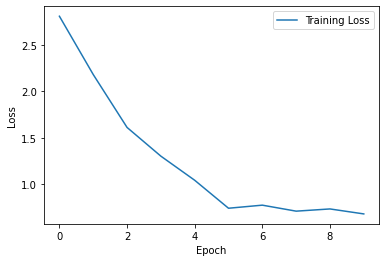

In [32]:
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

150/150 [==============================] - 11s 57ms/step - loss: 0.6068 - accuracy: 0.6950 - precision: 0.5928 - recall: 0.7583 - auc: 0.7738


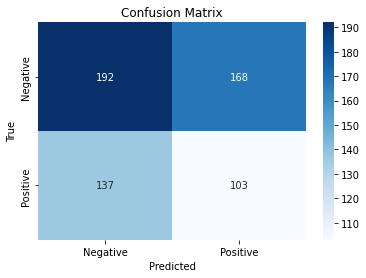

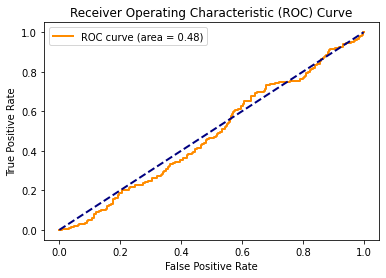

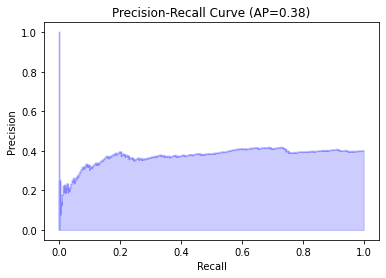

In [33]:
# Evaluate the model on the validation set
validation_eval = dnmodel.evaluate(validation_generator)

# Generate predictions on the validation set
y_pred = dnmodel.predict(validation_generator)

# Get true labels
y_true = validation_generator.classes

from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
# Confusion matrix
cm = confusion_matrix(y_true, np.round(y_pred))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('dncm')
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.savefig('dnroc')
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_true, y_pred)
average_precision = average_precision_score(y_true, y_pred)
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (AP={:.2f})'.format(average_precision))
plt.savefig('dnrc')
plt.show()

**EfficientNetB0**

In [37]:
# Load pre-trained EfficientNetB0 model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze convolutional layers
for layer in base_model.layers:
    layer.trainable = False

# Create a new model on top of the EfficientNetB0 base
enmodel = Sequential()
enmodel.add(base_model)
enmodel.add(GlobalAveragePooling2D())
enmodel.add(Dense(512, activation='relu'))
enmodel.add(Dropout(0.5))
enmodel.add(Dense(1, activation='sigmoid'))  # Binary classification, so 1 output neuron with sigmoid activation
enmodel.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 7, 7, 1280)        4049571   
_________________________________________________________________
global_average_pooling2d_4 ( (None, 1280)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 512)               655872    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 513       
Total params: 4,705,956
Trainable params: 656,385
Non-trainable params: 4,049,571
_________________________________________________________________


In [38]:
enmodel.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall', 'AUC'])

In [39]:
# Define callbacks
filepath = 'best_model_en.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
lrp = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=2)

# Combine callbacks in a list
callbacks = [checkpoint, early_stopping, lrp]

# Train the model with callbacks
history = enmodel.fit(train_generator, epochs=10,steps_per_epoch= 50, callbacks=callbacks)

Epoch 1/10
50/50 [==============================] - 9s 58ms/step - loss: 0.7352 - accuracy: 0.5600 - precision: 0.4615 - recall: 0.4390 - auc: 0.6185
Epoch 2/10
50/50 [==============================] - 3s 56ms/step - loss: 0.6459 - accuracy: 0.6800 - precision: 0.6742 - recall: 0.6316 - auc: 0.7225
Epoch 3/10
50/50 [==============================] - 3s 57ms/step - loss: 0.7114 - accuracy: 0.6450 - precision: 0.6364 - recall: 0.6931 - auc: 0.6943
Epoch 4/10
50/50 [==============================] - 3s 61ms/step - loss: 0.6686 - accuracy: 0.6450 - precision: 0.6292 - recall: 0.5957 - auc: 0.7372
Epoch 5/10
50/50 [==============================] - 3s 57ms/step - loss: 0.6113 - accuracy: 0.6750 - precision: 0.6739 - recall: 0.6392 - auc: 0.7395
Epoch 6/10
50/50 [==============================] - 3s 56ms/step - loss: 0.4939 - accuracy: 0.7250 - precision: 0.7158 - recall: 0.7083 - auc: 0.8308
Epoch 7/10
50/50 [==============================] - 3s 57ms/step - loss: 0.5010 - accuracy: 0.7600 -

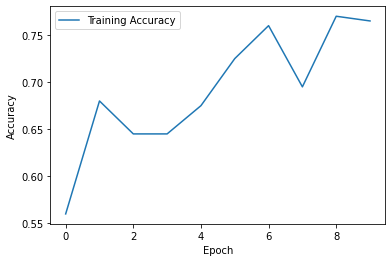

In [40]:
# Plot training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

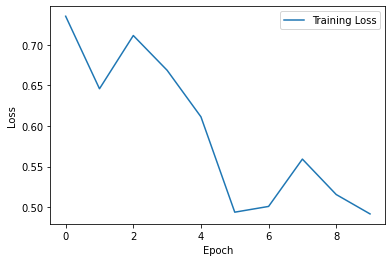

In [41]:
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

150/150 [==============================] - 10s 58ms/step - loss: 0.5832 - accuracy: 0.6750 - precision: 0.5779 - recall: 0.6958 - auc: 0.7632


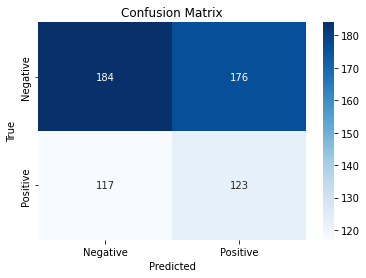

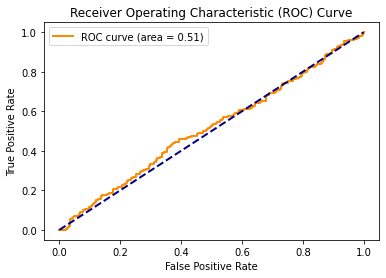

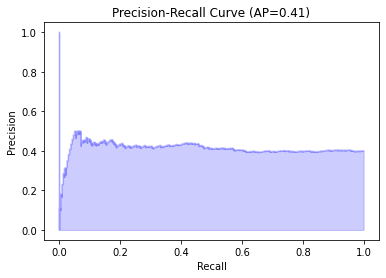

In [42]:
# Evaluate the model on the validation set
validation_eval = enmodel.evaluate(validation_generator)

# Generate predictions on the validation set
y_pred = enmodel.predict(validation_generator)

# Get true labels
y_true = validation_generator.classes

from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
# Confusion matrix
cm = confusion_matrix(y_true, np.round(y_pred))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('encm')
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.savefig('enroc')
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_true, y_pred)
average_precision = average_precision_score(y_true, y_pred)
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (AP={:.2f})'.format(average_precision))
plt.savefig('enrc')
plt.show()

**EfficientNetB3**

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import GaussianNoise, GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau


In [48]:

base_model = tf.keras.applications.EfficientNetB3(weights='imagenet', input_shape=(224,224,3), include_top=False)

for layer in base_model.layers:
    layer.trainable=False
model = Sequential()
model.add(base_model)
model.add(GaussianNoise(0.25))
model.add(GlobalAveragePooling2D())
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(GaussianNoise(0.25))
model.add(Dropout(0.25))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb3 (Functional)  (None, 7, 7, 1536)        10783535  
_________________________________________________________________
gaussian_noise (GaussianNois (None, 7, 7, 1536)        0         
_________________________________________________________________
global_average_pooling2d_5 ( (None, 1536)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 512)               786944    
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
gaussian_noise_1 (GaussianNo (None, 512)               0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)              

In [49]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy','Precision','Recall','AUC'])

In [50]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
lrp=ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=2)
filepath='best_model_enb3.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
call=[checkpoint,lrp]
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    steps_per_epoch= 50,
    callbacks=call
    )

Epoch 1/10
50/50 [==============================] - 26s 316ms/step - loss: 1.0553 - accuracy: 0.5350 - precision: 0.5049 - recall: 0.5532 - auc: 0.5602 - val_loss: 0.6921 - val_accuracy: 0.6517 - val_precision: 0.5394 - val_recall: 0.8833 - val_auc: 0.7117

Epoch 00001: val_accuracy improved from -inf to 0.65167, saving model to best_model_enb3.h5


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/10
50/50 [==============================] - 13s 253ms/step - loss: 0.7157 - accuracy: 0.6500 - precision: 0.6571 - recall: 0.6699 - auc: 0.7207 - val_loss: 0.7358 - val_accuracy: 0.6600 - val_precision: 0.5476 - val_recall: 0.8625 - val_auc: 0.7776

Epoch 00002: val_accuracy improved from 0.65167 to 0.66000, saving model to best_model_enb3.h5
Epoch 3/10
50/50 [==============================] - 12s 249ms/step - loss: 0.7882 - accuracy: 0.6500 - precision: 0.6768 - recall: 0.6381 - auc: 0.6979 - val_loss: 1.0090 - val_accuracy: 0.5967 - val_precision: 0.4979 - val_recall: 0.9917 - val_auc: 0.7545

Epoch 00003: val_accuracy did not improve from 0.66000
Epoch 4/10
50/50 [==============================] - 13s 255ms/step - loss: 0.6276 - accuracy: 0.7150 - precision: 0.7059 - recall: 0.7273 - auc: 0.7705 - val_loss: 0.7305 - val_accuracy: 0.6633 - val_precision: 0.5470 - val_recall: 0.9208 - val_auc: 0.7679

Epoch 00004: val_accuracy improved from 0.66000 to 0.66333, saving model to 

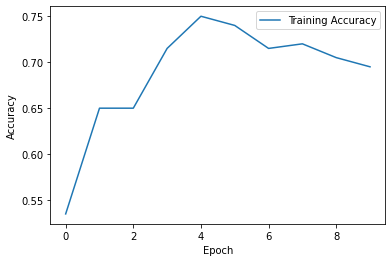

In [51]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

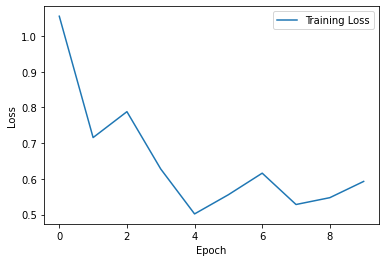

In [52]:
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [53]:
# Generate predictions on validation set
y_pred = model.predict(validation_generator)

# Get true labels
y_true = validation_generator.classes

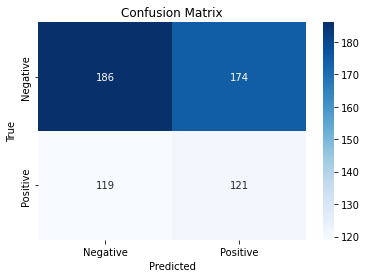

In [54]:
# Confusion matrix
cm = confusion_matrix(y_true, np.round(y_pred))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('en3cm')
plt.show()


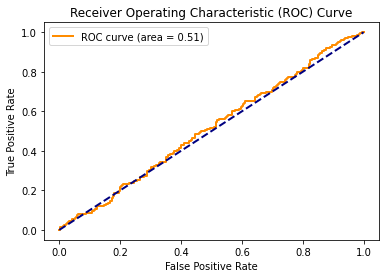

In [55]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.savefig('en3roc')
plt.show()

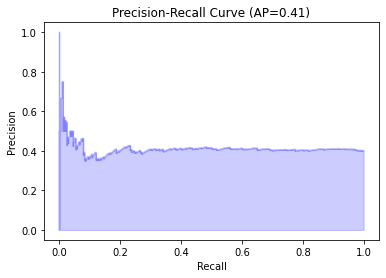

In [56]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_true, y_pred)
average_precision = average_precision_score(y_true, y_pred)
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (AP={:.2f})'.format(average_precision))
plt.savefig('en3rc')
plt.show()